# Visualizing where your objective is being sampled

Tim Head, August 2016.

In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.set_cmap("viridis")

Bayesian optimization or sequential model-based optimization uses a surrogate model
to model the expensive to evaluate objective function `func`. It is this model
that is used to determine at which points to evaluate the expensive objective next.

To help understand why the optimization process is proceeding the way it is, it is
useful to plot the location and order of the points at which the objective is
evaluated. If everything is working as expected, early samples will be spread over
the whole parameter space and later samples should cluster around the minimum.

The `plot_evaluations()` function helps with visualizing the location and order
in which samples are evaluated for objecitves with an arbitrary number of dimensions.


# Toy models

We will use two different toy models to demonstrate how `plot_evaluations()` works.

The first model is the `branin` function which has two dimensions and three minima.

The second model is the `hart6` function which has six dimension which makes it hard to visualize. This will show off the utility of `plot_evaluations()`.

In [19]:
from skopt.benchmarks import branin as branin_
from skopt.benchmarks import hart6 as hart6_


def branin(x, noise_level=0.):
    return branin_(x) + noise_level * np.random.randn()

def hart6(x, noise_level=0.):
    return hart6_(x[:6]) + noise_level * np.random.randn()

# Starting with `branin`

To start let's take advantage of the fact that `branin` is a simple
function which can be visualised in two dimensions.

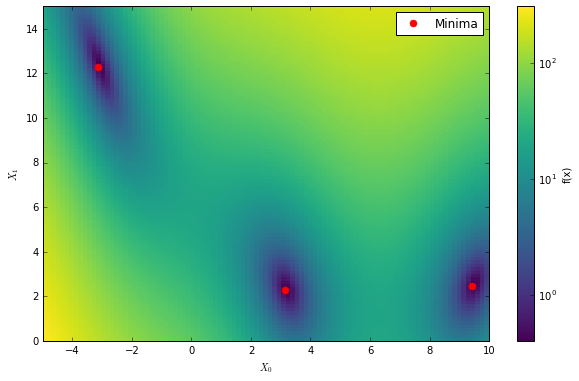

In [3]:
from matplotlib.colors import LogNorm

def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    ax.legend(loc="best", numpoints=1)
    
    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])
    
plot_branin()

Next we use an extra trees based minimizer to find one of the minima of the
`branin` function. Then we visualize at which points the objective is being
evaluated using `plot_evaluations()`.

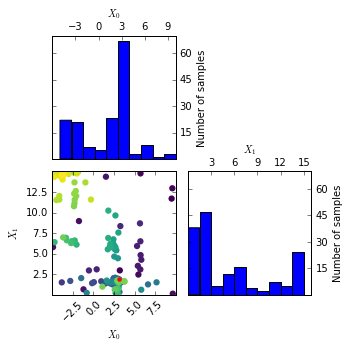

In [24]:
from functools import partial
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize


bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 160

forest_res = forest_minimize(branin, bounds, n_calls=n_calls, base_estimator="et",
                             random_state=4)

_ = plot_evaluations(forest_res, bins=10)

`plot_evaluations()` creates a grid of size `n_dims` by `n_dims`. The diagonal shows
histograms for each of the dimensions. In the lower triangle (just one plot in this case)
a two dimensional scatter plot of all points is shown. The order in which points were
evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier
samples and lighter/yellow colors correspond to later samples. A red point shows the location
of the minimum found by the optimization process.

You should be able to see that points start clustering around the location of the true
miminum. The histograms show that the objective is evaluated more often at locations near
to one of the three minima.

Compare this to a mimizer which picks points at random. There is no structure visible
in the order in which it evaluates the objective.

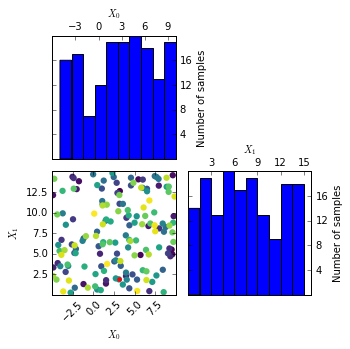

In [25]:
dummy_res = dummy_minimize(branin, bounds, n_calls=n_calls, random_state=4)

_ = plot_evaluations(dummy_res, bins=10)

# Six dimensions

Visualising what happens in two dimensions is easy, where `plot_evaluations()`
starts to be useful is when the number of dimensions grows. It takes care of many
of the more mundane things needed to make good scatter plots of all combinations
of dimensions.

The next example uses `hart6` which has six dimensions.

In [11]:
bounds = [(0., 1.),] * 6

forest_res = forest_minimize(hart6, bounds, n_calls=n_calls,
                             base_estimator="et", random_state=4)

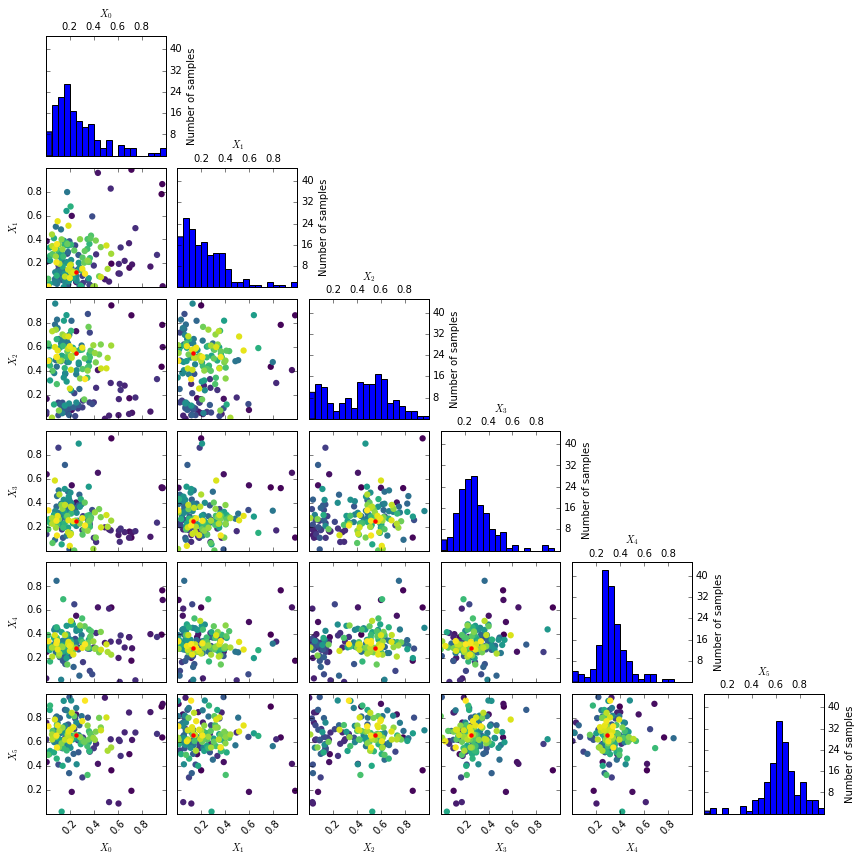

In [12]:
_ = plot_evaluations(forest_res)

To make things more interesting let's add two dimension to the problem. As `hart6`
only depends on six dimensions we know that for this problem the new dimensions will
be "flat" or uninformative.

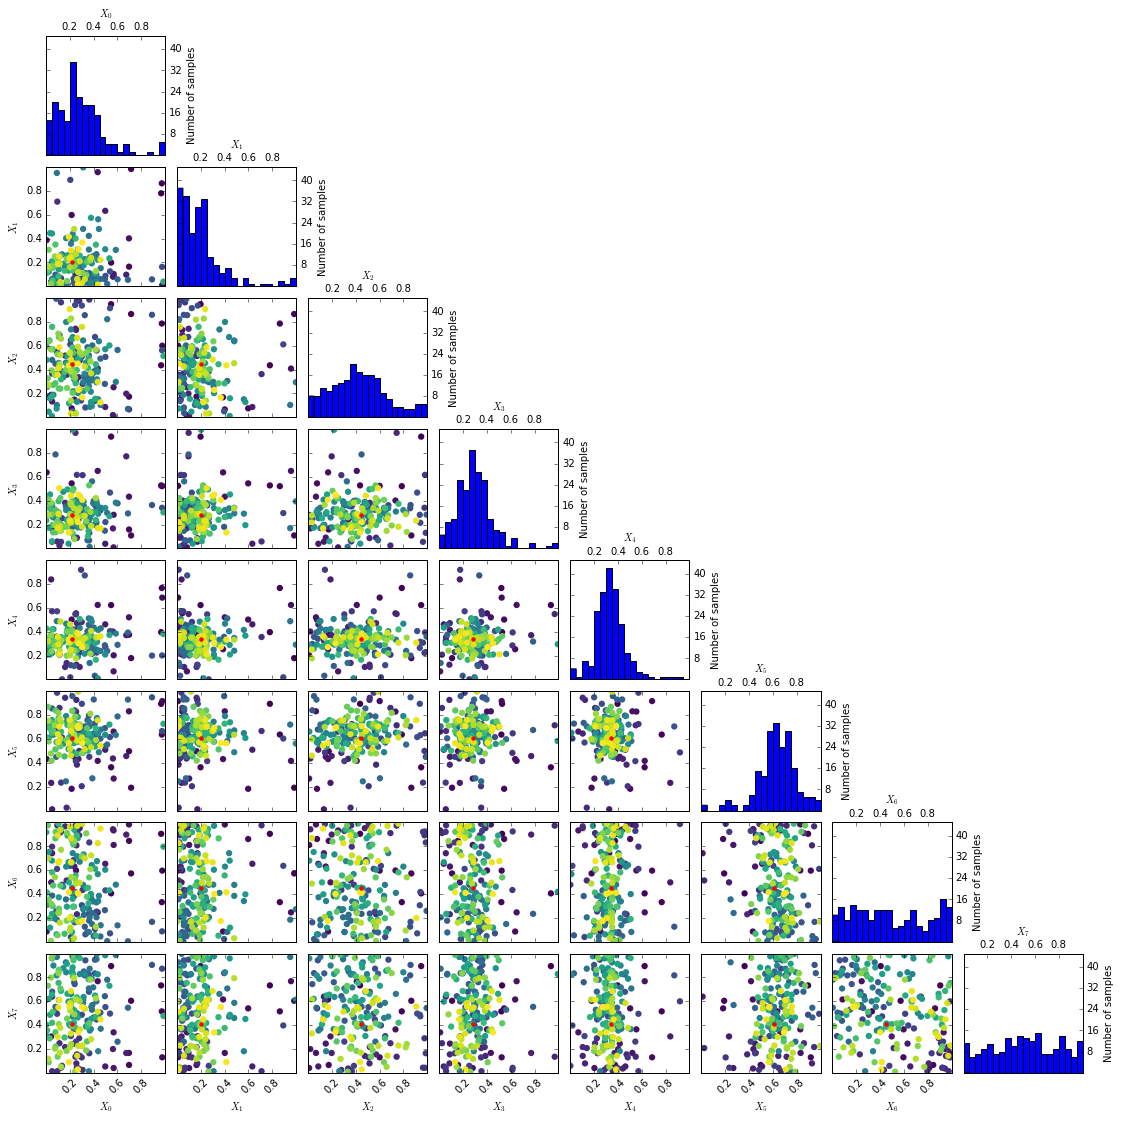

In [22]:
bounds = [(0., 1.),] * 8
n_calls = 200

forest_res = forest_minimize(hart6, bounds, n_calls=n_calls,
                             base_estimator="et", random_state=4)

_ = plot_evaluations(forest_res)